# 3 classic ML algorithms
## 3.Neural Network Regression (MLP)

Train shape: (1000, 30)  Test shape: (460, 30)
Top features: ['OverallQual', 'GrLivArea', 'GarageCars', 'ExterQual', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'BsmtQual', 'KitchenQual', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'MasVnrArea', 'GarageYrBlt', 'Fireplaces', 'GarageFinish', 'GarageType', 'HeatingQC', 'BsmtFinSF1', 'Foundation', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'BsmtExposure', 'HalfBath', 'LotArea', 'LotShape', 'CentralAir', 'GarageCond']
[hidden=(64,), act=relu, alpha=0.0001, lr=0.001] MSE=0.1459
[hidden=(64,), act=tanh, alpha=0.0001, lr=0.001] MSE=0.1900
[hidden=(64,), act=relu, alpha=0.001, lr=0.001] MSE=0.1460
[hidden=(64,), act=tanh, alpha=0.001, lr=0.001] MSE=0.1899
[hidden=(64,), act=relu, alpha=0.01, lr=0.001] MSE=0.1458
[hidden=(64,), act=tanh, alpha=0.01, lr=0.001] MSE=0.1899
[hidden=(64,), act=relu, alpha=0.0001, lr=0.0005] MSE=0.1536
[hidden=(64,), act=tanh, alpha=0.0001, lr=0.0005] MSE=0.1924
[hidden=(64,), act=relu, alpha=0.001, lr=0.0005] 

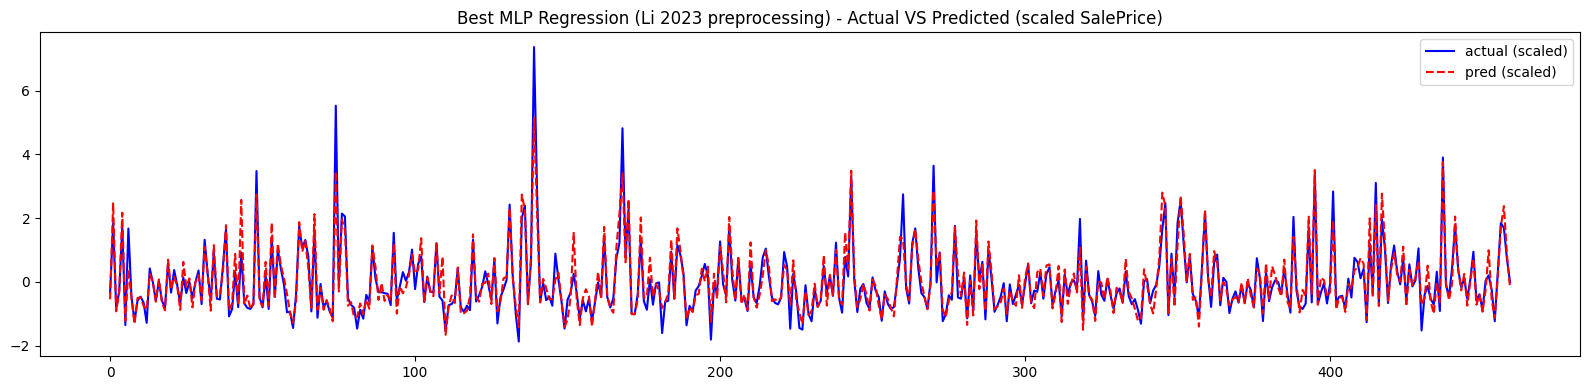

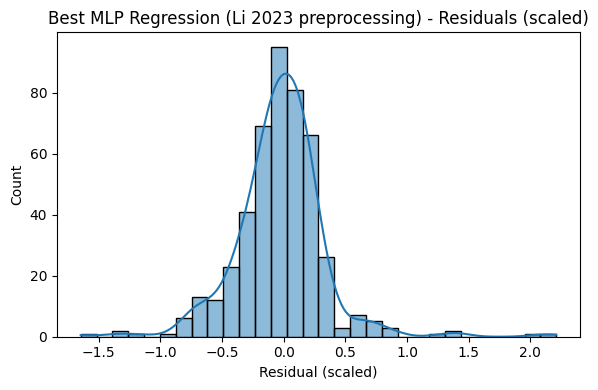

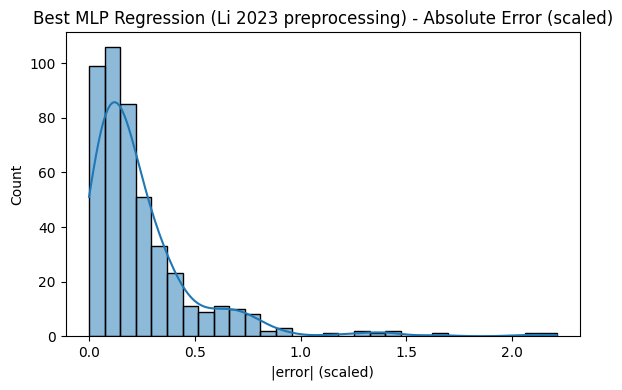

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

CSV_PATH = "train.csv"
def preprocess_and_split_li2023(csv_path=CSV_PATH, top_k=30, random_state=42):
    df = pd.read_csv(csv_path)

    cols_to_drop = [
        "Alley", "YearRemodAdd", "FireplaceQu", "PoolQC",
        "Fence", "MasVnrType", "MiscFeature", "Id"
    ]
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

    target = "SalePrice"
    y = df[target]
    X = df.drop(columns=[target])

    numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
    categorical_cols = X.select_dtypes(include=["object"]).columns
    X[numeric_cols] = X[numeric_cols].apply(lambda col: col.fillna(col.mean()))
    X[categorical_cols] = X[categorical_cols].fillna("NONE")
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    if len(categorical_cols) > 0:
        X[categorical_cols] = encoder.fit_transform(X[categorical_cols])
    scaler_x = StandardScaler()
    X_scaled = pd.DataFrame(scaler_x.fit_transform(X), columns=X.columns)
    X_scaled[target] = y.values
    corr = X_scaled.corr()[target].drop(target)
    corr_sorted = corr.abs().sort_values(ascending=False)
    top_features = corr_sorted.index[:top_k].tolist()

    X_final = X_scaled[top_features]
    y_final = y.copy()

    # 1000 / 460 split
    test_size = 460 / len(X_final)
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y_final,
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
    )

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train_scaled": y_train_scaled,
        "y_test_scaled": y_test_scaled,
        "top_features": top_features,
    }

def evaluate_and_plot_scaled(name, y_true_scaled, y_pred_scaled):
    mse = mean_squared_error(y_true_scaled, y_pred_scaled)
    mae = mean_absolute_error(y_true_scaled, y_pred_scaled)
    rmse = np.sqrt(mse)

    print(f"\n=== {name} (SCALED target) ===")
    print(f"MSE:  {mse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    plt.figure(figsize=(16, 4))
    plt.plot(y_true_scaled, label="actual (scaled)", color="blue")
    plt.plot(y_pred_scaled, label="pred (scaled)", color="red", linestyle="--")
    plt.title(f"{name} - Actual VS Predicted (scaled SalePrice)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    residuals = y_true_scaled - y_pred_scaled
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{name} - Residuals (scaled)")
    plt.xlabel("Residual (scaled)")
    plt.tight_layout()
    plt.show()

    abs_err = np.abs(residuals)
    plt.figure(figsize=(6, 4))
    sns.histplot(abs_err, bins=30, kde=True)
    plt.title(f"{name} - Absolute Error (scaled)")
    plt.xlabel("|error| (scaled)")
    plt.tight_layout()
    plt.show()

def tune_mlp_regressor(X_train, X_test, y_train_scaled, y_test_scaled):
    hidden_layer_options = [
        (64,),
        (128,),
        (128, 64),
        (256, 128),
    ]
    learning_rates = [0.001, 0.0005]
    alphas = [0.0001, 0.001, 0.01]
    activations = ["relu", "tanh"]

    best_mse = float("inf")
    best_cfg = None
    all_results = []

    for hl in hidden_layer_options:
        for lr in learning_rates:
            for alpha in alphas:
                for act in activations:
                    mlp = MLPRegressor(
                        hidden_layer_sizes=hl,
                        activation=act,
                        alpha=alpha,
                        learning_rate_init=lr,
                        max_iter=600,
                        random_state=42,
                        early_stopping=True,
                        n_iter_no_change=20,
                        validation_fraction=0.1,
                    )
                    mlp.fit(X_train, y_train_scaled)
                    pred_scaled = mlp.predict(X_test)
                    mse = mean_squared_error(y_test_scaled, pred_scaled)

                    cfg = {
                        "hidden_layer_sizes": hl,
                        "learning_rate_init": lr,
                        "alpha": alpha,
                        "activation": act,
                        "mse": mse,
                    }
                    all_results.append(cfg)

                    print(
                        f"[hidden={hl}, act={act}, alpha={alpha}, lr={lr}] "
                        f"MSE={mse:.4f}"
                    )

                    if mse < best_mse:
                        best_mse = mse
                        best_cfg = {
                            **cfg,
                            "model": mlp,
                            "y_pred_scaled": pred_scaled,
                        }

    print("\n===================")
    print(" BEST MLP CONFIGURATION")
    print("===================")
    print(best_cfg)

    return best_cfg, all_results

if __name__ == "__main__":
    data = preprocess_and_split_li2023(CSV_PATH, top_k=30, random_state=42)

    X_train = data["X_train"]
    X_test = data["X_test"]
    y_train_scaled = data["y_train_scaled"]
    y_test_scaled = data["y_test_scaled"]

    print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
    print("Top features:", data["top_features"])

    best_cfg, all_results = tune_mlp_regressor(
        X_train, X_test, y_train_scaled, y_test_scaled
    )
    best_mlp = best_cfg["model"]
    best_pred_scaled = best_cfg["y_pred_scaled"]

    evaluate_and_plot_scaled(
        "Best MLP Regression (Li 2023 preprocessing)",
        y_test_scaled,
        best_pred_scaled,
    )
